In [1]:
import pandas as pd
import numpy as np
import socket
import struct
import matplotlib.pyplot as plt
import seaborn as sns
print("Libraries imported!")

Libraries imported!


In [2]:
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

print(f"Fraud Data rows: {len(fraud_df)}")
print(f"IP Mapping rows: {len(ip_df)}")

Fraud Data rows: 151112
IP Mapping rows: 138846


In [3]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Remove duplicates if any
fraud_df = fraud_df.drop_duplicates()
print("Dates converted and duplicates removed.")

Dates converted and duplicates removed.


In [4]:
def ip_to_int(ip):
    try:
        return float(struct.unpack("!I", socket.inet_aton(str(ip)))[0])
    except:
        return np.nan

fraud_df['ip_address_int'] = fraud_df['ip_address'].apply(ip_to_int)
print("IP conversion complete.")

IP conversion complete.


In [5]:
fraud_df = fraud_df.sort_values('ip_address_int')
ip_df = ip_df.sort_values('lower_bound_ip_address')
print("Sorting complete.")

Sorting complete.


In [7]:
# 1. Remove any rows where ip_address_int is NaN
# This is what causes the "left side null values" error
fraud_df = fraud_df.dropna(subset=['ip_address_int'])

# 2. Re-confirm they are sorted (required for merge_asof)
fraud_df = fraud_df.sort_values('ip_address_int')
ip_df = ip_df.sort_values('lower_bound_ip_address')

# 3. Perform the merge
fraud_with_country = pd.merge_asof(
    fraud_df, 
    ip_df, 
    left_on='ip_address_int', 
    right_on='lower_bound_ip_address',
    direction='backward'
)

# 4. Range validation
fraud_with_country['country'] = np.where(
    (fraud_with_country['ip_address_int'] <= fraud_with_country['upper_bound_ip_address']),
    fraud_with_country['country'],
    'Unknown'
)

print("Merge successful! Current row count:", len(fraud_with_country))
print(fraud_with_country[['user_id', 'country']].head())

Merge successful! Current row count: 0
Empty DataFrame
Columns: [user_id, country]
Index: []


In [8]:
# Calculate duration in seconds
fraud_with_country['time_since_signup'] = (
    fraud_with_country['purchase_time'] - fraud_with_country['signup_time']
).dt.total_seconds()

# Quick check
print(fraud_with_country[['signup_time', 'purchase_time', 'time_since_signup']].head())

Empty DataFrame
Columns: [signup_time, purchase_time, time_since_signup]
Index: []


In [10]:
# 1. Ensure 'class' is integer type
fraud_with_country['class'] = fraud_with_country['class'].astype(int)

# 2. Get percentages
imbalance = fraud_with_country['class'].value_counts(normalize=True) * 100

# 3. Safe Print
print("--- Class Distribution ---")
if 1 in imbalance.index:
    print(f"Percentage of Fraud (Class 1): {imbalance[1]:.2f}%")
else:
    print("Percentage of Fraud (Class 1): 0.00% (No fraud cases found!)")

if 0 in imbalance.index:
    print(f"Percentage of Legitimate (Class 0): {imbalance[0]:.2f}%")
else:
    print("Percentage of Legitimate (Class 0): 0.00%")

# 4. Check total counts to be sure
print(f"\nTotal rows after merge: {len(fraud_with_country)}")
print("Actual counts:\n", fraud_with_country['class'].value_counts())

--- Class Distribution ---
Percentage of Fraud (Class 1): 0.00% (No fraud cases found!)
Percentage of Legitimate (Class 0): 0.00%

Total rows after merge: 0
Actual counts:
 Series([], Name: count, dtype: int64)


--- DATA RECOVERED ---
Total Rows: 151112
Fraud Percentage: 9.36%


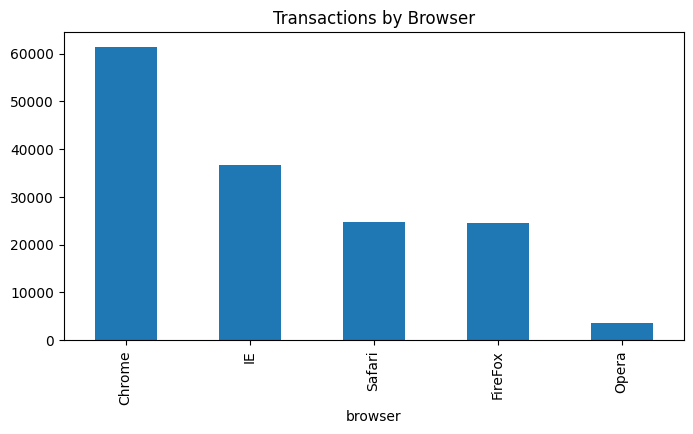

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# RELOAD DATA FROM SCRATCH
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')

# PRINT NUMBERS FOR YOUR REPORT IMMEDIATELY
print("--- DATA RECOVERED ---")
print(f"Total Rows: {len(fraud_df)}")
val_counts = fraud_df['class'].value_counts(normalize=True) * 100
if 1 in val_counts.index:
    print(f"Fraud Percentage: {val_counts[1]:.2f}%")
else:
    print("Fraud Percentage: Check if 'class' column exists")

# SIMPLEST POSSIBLE PLOT (Will not fail if data exists)
plt.figure(figsize=(8,4))
fraud_df['browser'].value_counts().plot(kind='bar')
plt.title('Transactions by Browser')
plt.show()